Block matching algorithm is one key stage in patch-based image processing algorithm. This example
shows how block matching algorithm can be implemented efficiently and easily with the help of
LazyDistances.jl.

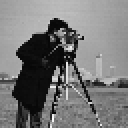

In [1]:
using Images
using TestImages
using LazyDistances

img = imresize(float.(testimage("cameraman")), (64, 64))

For given patch radius `rₚ`, we can get a patch at each pixel `p` in the image.

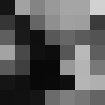

In [2]:
p = CartesianIndex(20, 30)
rₚ = CartesianIndex(3, 3) # patch size (7, 7)
patch_p = img[p-rₚ:p+rₚ]

For each pixel `p`, what block matching does is to find a group of patches that are similar to
`patch_p`.

In [3]:
function block_matching(f, img, p, rₚ; num_patches=10)
    R = CartesianIndices(img)
    # to simplify the implementation and not consider border case
    candidates = first(R)+rₚ:last(R)-rₚ

    # Measure the similarity of two patches with `f`. Typically, `f` is `sqeuclidean`
    patch_p = @view img[p-rₚ:p+rₚ]
    dist = map(candidates) do q
        patch_q = @view img[q-rₚ:q+rₚ]
        f(patch_p, patch_q)
    end |> vec

    # sort from small(the most similar) to large(the least similar)
    # TODO: use partialsortperm! to reduce allocation
    order = partialsortperm(dist, 1:num_patches) # 34.394 μs (4 allocations: 26.44 KiB)
    qs = @view candidates[order]
end

block_matching (generic function with 1 method)

Here we get a group of patches that are similar to `patch_p` in the sense of F-norm.

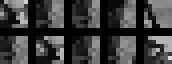

In [4]:
matched_patches = block_matching(SqEuclidean(), img, p, rₚ) # 212.266 μs (7 allocations: 39.83 KiB)
mosaicview(map(q->img[q-rₚ:q+rₚ], matched_patches); npad=2, nrow=2)

This implementation looks good, but there's one key challenge here, that we need to loop over the
whole image and do block matching for each pixel. This means we are doing a massive computation
and there are a lot of unnecessary redundant calculation if we are doing a simple loop.

For example, this is what a naive implementation of patch-based algorithm might looks like

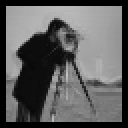

In [5]:
function patched_mean(img, rₚ; num_patches=10)
    out = fill(zero(eltype(img)), axes(img))

    R = CartesianIndices(img)
    for p in first(R)+rₚ:last(R)-rₚ
        matched_patches = block_matching(SqEuclidean(), img, p, rₚ; num_patches=num_patches)
        out[p] = mapreduce(q->img[q], +, matched_patches)/length(matched_patches)
    end
    out
end

patched_mean(img, rₚ) # 794.575 ms (23549 allocations: 130.86 MiB)

What's wrong here? There are a lot of repeated calculation in `f(patch_q, patch_q)`. For example,
when `f = SqEuclidean()`

$$
d = \sum_{p, q} (I[p] - I[q])^2
$$

Please do note that `(I[p] -  I[q])^2` is repeatedly calculated in the whole iteration. One single
calculation of such is not expensive, but it is a siginficant amount of work when it's in a nested
for-loops.

Among all the existing MATLAB and Python implementations, there are two things done to work around
this key challenge. The first workaround is to pre-calculate the pixelwise distances and then
reuse it in the inner loop. It works quite well but it also introduces another key challenge, that
the memeory will complain for large image size; to store the result for image with size `(256,
256)` we need an array of size `(256, 256, 256, 256)`, which is 32 GB memory and
unaccptable. The second workaround, is then to specify a search window, that to only search
similar patches in a larger neighborhood of pixel `p`. For search window size `(17, 17)`, the
memeory needed to store the result is 0.14 GB, which is more acceptable.

We are not going to explore how search window and pre-calculation are implemented because this is
quite a dirty work; you almost have to write the whole implementation in a long long for-loop.
Instead, we are going to see how this can be efficiently and easily implemented with
LazyDistances.jl.

A `PairwiseDistance` is a lazy array that mimics the output of pairwise distance.

In [6]:
eval_op(x, y) = abs2(x - y)
pointwise_dist = PairwiseDistance(eval_op, img, img); # 1.982 ns (0 allocations: 0 bytes)

# pointwise_dist[I, J] is defined as f(img[I], img[J])
pq1 = pointwise_dist[CartesianIndex(1, 1), CartesianIndex(2, 2)]
pq2 = eval_op(img[CartesianIndex(1, 1)], img[CartesianIndex(2, 2)])
pq1 == pq2

true

Generating this array does not doing any actual computation; the computation does not happen until
you ask for the data. We can also build a patchwise distance with this.

In [7]:
R = CartesianIndices(img)
valid_R = first(R)+rₚ:last(R)-rₚ

# For simplicity, we didn't deal with boundary condition here, so it will error
# when we index with `patchwise_dist[1, 1, 1, 1]`.
patchwise_dist = let rₚ = rₚ, img = img
        PairwiseDistance(SqEuclidean(), img, img) do p, q
        # here we specify how patches are generated from given pixel p and q
        p, q = CartesianIndex(p), CartesianIndex(q)
        @views img[p-rₚ:p+rₚ], img[q-rₚ:q+rₚ]
    end
end; # 4.903 ns (0 allocations: 0 bytes)

p = CartesianIndex(4, 4)
q = CartesianIndex(5, 5)
# @btime getindex($patchwise_dist, $p, $q) # 54.374 ns (0 allocations: 0 bytes)
patchwise_dist[p, q] == sqeuclidean(img[p-rₚ:p+rₚ], img[q-rₚ:q+rₚ])

true

This way we have generated the patchwise distances, although the actual computation doesn't happen
until we need it.

In [8]:
function patched_mean_fast(img, rₚ; num_patches=10)
    out = fill(zero(eltype(img)), axes(img))

    patchwise_dist = PairwiseDistance(SqEuclidean(), img, img) do p, q
        p, q = CartesianIndex(p), CartesianIndex(q)
        @views img[p-rₚ:p+rₚ], img[q-rₚ:q+rₚ]
    end

    R = CartesianIndices(img)
    R0 = first(R)+rₚ:last(R)-rₚ
    for p in R0
        dist = vec(patchwise_dist[p, R0])
        matched_patches = R0[partialsortperm(dist, 1:num_patches)]
        out[p] = mapreduce(q->img[q], +, matched_patches)/length(matched_patches)
    end
    out
end

# @btime patched_mean_fast($img, rₚ);
#  657.075 ms (26913 allocations: 131.63 MiB)
# @btime patched_mean($img, rₚ);
#  797.023 ms (23549 allocations: 130.86 MiB)
patched_mean_fast(img, rₚ) == patched_mean(img, rₚ)

true

Great! We haven't incoporate the pre-calculation trick yet, we still get a bit faster by making
things lazy.

More generally speaking, pre-calculation is just a cache. `PairwiseDistance` supports a so-called
`LocalWindowCache` cache which stores the results in neighborhood `(p, q-r:q+r)` for each pixel
pair `(p, q)`.

In [9]:
eval_op(x, y) = abs2(x - y)
pointwise_dist = PairwiseDistance(eval_op, img, img, LocalWindowCache((7, 7))) # 32.575 μs (3 allocations: 980.12 KiB)

pq1 = pointwise_dist[CartesianIndex(1, 1), CartesianIndex(2, 2)]
pq2 = eval_op(img[CartesianIndex(1, 1)], img[CartesianIndex(2, 2)])
pq1 == pq2

true

This requires a bit more memory because we will allocate a cache array of size `(64, 64, 7, 7)`,
which is about 788 KB memory for Float32 type. Reusing the cache requires us to implement the
SqEuclidean function on it. Lucikly we can get this done very efficiently and quickly in Julia.

In [10]:
patchwise_dist = let img=img, rₚ=rₚ
        eval_op(x, y) = abs2(x - y)
        pointwise_dist = PairwiseDistance(eval_op, img, img, LocalWindowCache((7, 7)))

        patch_eval_op(patch_p, patch_q) = mapreduce((p, q)->pointwise_dist[p, q], +, patch_p, patch_q)
        PairwiseDistance{Float32}(patch_eval_op, img, img) do p, q
        p, q = CartesianIndex(p), CartesianIndex(q)
        p-rₚ:p+rₚ, q-rₚ:q+rₚ
    end
end;

# TODO: unfortunately, this is currently slower than the non-cache version: 10x slower :cry:
# @btime getindex($patchwise_dist, $p, $q) # 526.684 ns (3 allocations: 448 bytes)
patchwise_dist[p, q] == sqeuclidean(img[p-rₚ:p+rₚ], img[q-rₚ:q+rₚ])

false

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*